In [2]:
import findspark
findspark.init()
import pyspark

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime, time 

In [4]:
spark = SparkSession.builder.enableHiveSupport().master("local[*]").appName("Twitter Stat").getOrCreate() 

In [8]:
data = spark.read.parquet("../data/twitter.parquet")

root
 |-- id: long (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- url: string (nullable = true)
 |-- reply_to: double (nullable = true)
 |-- retweets: long (nullable = true)
 |-- favorites: long (nullable = true)
 |-- likes_id: string (nullable = true)
 |-- retweets_id: string (nullable = true)
 |-- picture: string (nullable = true)
 |-- replies: long (nullable = true)
 |-- mod_text: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [46]:
_sizes2 = data.withColumn("len", length(col("text"))).filter(col("len").isNotNull()).filter(col("date_time")>datetime.datetime(2017, 11, 7, 0, 0, 0)).select(col("len")).collect()

In [45]:
data.filter(col("date_time")>datetime.datetime(2017, 11, 7, 0, 0, 0)).select(col("date_time")).count()

159867

In [48]:
len(_sizes2)

157526

# Visualisation

In [23]:
from __future__ import absolute_import
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
# SEA-BORN Modification
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set(rc={'figure.figsize': (12, 8)})
    sns.set(font_scale=1.8)
    sns.set_style("whitegrid")

In [33]:
set_style()
def plot_Hist(data, save=False, bins=None, title='Lenght of Twitts', _xlabel='Lenght', yscale='linear'):
    ax = sns.distplot(data, bins=bins, color='firebrick', norm_hist=False, kde=False, hist_kws={"alpha": 0.8},
                      label='Sample')
    ax.set_yscale(yscale)
    ax.set(xlabel=_xlabel, ylabel='Num. of tweets, '+yscale+' scale')
    plt.xlim(0, 320)
    plt.legend(loc=1)
    plt.tight_layout()
    if save:
        if not os.path.exists('Images/Histograms/'):
            os.makedirs('Images/Histograms/')
        plt.savefig('Images/Histograms/' + title + '.png')
    plt.show()

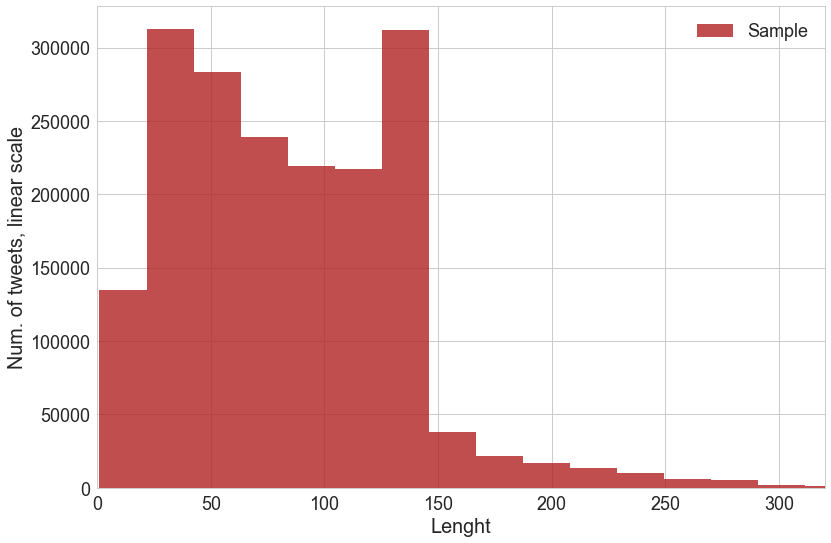

In [35]:
plot_Hist(_sizes)

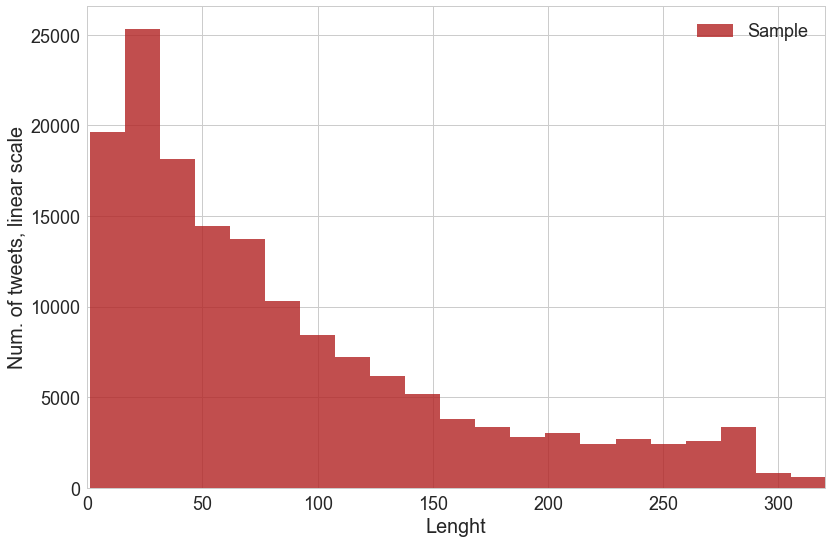

In [47]:
plot_Hist(_sizes2)